In [3]:
import nilearn
from nilearn import datasets, plotting
import os
import requests
import csv
import pandas as pd
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
base_dir = '/Users/aj/dmello_lab/fmri_connectivity_trees' # directory where repository lives

# get msdl and whole brain atlases and coords
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords

whole_data = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm', data_dir=f'{base_dir}/atlases/HarvardOxford')
# whole_coords = nilearn.plotting.find_parcellation_cut_coords(whole_data.labels)

[get_dataset_dir] Dataset found in /Users/aj/nilearn_data/msdl_atlas
[get_dataset_dir] Dataset found in /Users/aj/dmello_lab/fmri_connectivity_trees/atlases/HarvardOxford/fsl


ValueError: File not found: 'Background'

In [ ]:
# load 3d shapes
cort_shape = np.loadtxt(f'{base_dir}/code/functional_connectivity/abide/output/roi_time_series/40_MSDL/shape.csv', delimiter=',').astype(int)
 # cereb_shape = np.loadtxt('abide_30_diedrichsen_pooled_3d_shape.csv', delimiter=',').astype(int)
cort_pooled= np.loadtxt(f'{base_dir}/code/functional_connectivity/abide/output/roi_time_series/40_MSDL/pooled.csv', delimiter=',').reshape(cort_shape)

# load and reshape pooled time series
whole_shape = np.loadtxt(f'{base_dir}/code/functional_connectivity/abide/output/roi_time_series/40_HarvardOxford/shape.csv', delimiter=',').astype(int)
# cereb_pooled = np.loadtxt('abide_30_diedrichsen_pooled.csv', delimiter=',').reshape(cereb_shape)
whole_pooled = np.loadtxt(f'{base_dir}/code/functional_connectivity/abide/output/roi_time_series/40_HarvardOxford/pooled.csv', delimiter=',').reshape(whole_shape)

In [13]:
print(cort_pooled.shape)  # check shapes of loaded arrays
print(whole_pooled.shape) # check shapes of loaded arrays

(40, 195, 39)
(40, 195, 21)


In [ ]:
# load abide ids
with open(f'{base_dir}/datasets/abide/phenotypic/abide_ids.txt', 'r') as f:
    abide_ids = [line.strip() for line in f.readlines()]

# load mapped phenotypes
with open(f'{base_dir}/datasets/abide/phenotypic/phenotype.txt', 'r') as f:
    phenotype = [int(line.strip()) for line in f.readlines()]

## simple correlation matrices

In [23]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)

In [24]:
# separate timeseries for asd and tdc
def get_groups(pooled_subjects, phenotype):
    asd = []
    tdc = []
    for i in range(30):
        if phenotype[i] == 1:
            asd.append(pooled_subjects[i])
        else: tdc.append(pooled_subjects[i])
    asd = np.array(asd)
    tdc = np.array(tdc)

    return {'asd': asd, 'tdc': tdc}

In [25]:
cort_groups = get_groups(cort_pooled, phenotype)
# cereb_groups = get_groups(cereb_pooled, phenotype)
whole_groups = get_groups(whole_pooled, phenotype)

In [26]:
# calculate mean correlation matrix and mean corr arr
def get_mean_corr(pooled_subjects: dict, correlation_measure=correlation_measure):

    asd = pooled_subjects['asd']
    tdc = pooled_subjects['tdc']

    correlation_asd = correlation_measure.fit_transform(asd)
    mean_correlation_matrix_asd = correlation_measure.mean_

    correlation_tdc = correlation_measure.fit_transform(tdc)
    mean_correlation_matrix_tdc = correlation_measure.mean_

    mean_corr_asd = np.mean(mean_correlation_matrix_asd, axis=1)
    mean_corr_tdc = np.mean(mean_correlation_matrix_tdc, axis=1)
    
    # dictionary containing tuple with mean correlation matrix and mean correlation
    return {'asd': (correlation_asd, mean_correlation_matrix_asd, mean_corr_asd), 'tdc': (correlation_tdc, mean_correlation_matrix_tdc, mean_corr_tdc)}

In [28]:
#visualize asd and tdc corr side by side
def visualize_corr(asd_mat, tdc_mat):

    # Set the figure size and create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Wider figure for better readability

    # Set consistent color scale across both plots
    vmin = min(asd_mat.min(), tdc_mat.min())
    vmax = max(asd_mat.max(), tdc_mat.max())

    # Plot the first matrix
    im1 = axes[0].matshow(asd_mat, vmin=vmin, vmax=vmax, cmap='viridis')
    axes[0].set_title('ASD Cort')

    # Plot the second matrix
    axes[1].matshow(tdc_mat, vmin=vmin, vmax=vmax, cmap='viridis')
    axes[1].set_title('TDC Cort')

    # Add a shared colorbar without overlap
    cbar = fig.colorbar(im1, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.05, pad=0.05)
    cbar.ax.set_position([1, 0.15, 0.02, 0.7])  # [x, y, width, height]

    # Improve layout spacing
    plt.subplots_adjust(wspace=0.3, right=0.9)

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [29]:
# get cort corr matrices
mean_corr_cort = get_mean_corr(cort_groups)

# get cereb corr matrices
# mean_corr_cereb = get_mean_corr(cereb_groups)  

# get whole corr matrices
mean_corr_whole = get_mean_corr(whole_groups)

In [38]:
#visualize asd and tdc corr side by side
def visualize_corr(mean_corr, title='Correlation Matrices'):

    asd_mat = mean_corr['asd'][1]  # mean correlation matrix for ASD
    tdc_mat = mean_corr['tdc'][1]  # mean correlation matrix for TDC

    # Set the figure size and create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Wider figure for better readability

    # Set consistent color scale across both plots
    vmin = min(asd_mat.min(), tdc_mat.min())
    vmax = max(asd_mat.max(), tdc_mat.max())

    # Plot the first matrix
    im1 = axes[0].matshow(asd_mat, vmin=vmin, vmax=vmax, cmap='viridis')
    axes[0].set_title('ASD')

    # Plot the second matrix
    im2 = axes[1].matshow(tdc_mat, vmin=vmin, vmax=vmax, cmap='viridis')
    axes[1].set_title('TDC')

    # Add a shared colorbar without overlap
    cbar = fig.colorbar(im1, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.05, pad=0.05)
    cbar.ax.set_position([1, 0.15, 0.02, 0.7])  # [x, y, width, height]

    # Improve layout spacing
    plt.subplots_adjust(wspace=0.3, right=0.9)

    # Adjust layout
    plt.tight_layout()
    plt.show()

/var/folders/lg/kgxc1tq55372n0km3vwpwdtm0000gn/T/ipykernel_67158/979966279.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


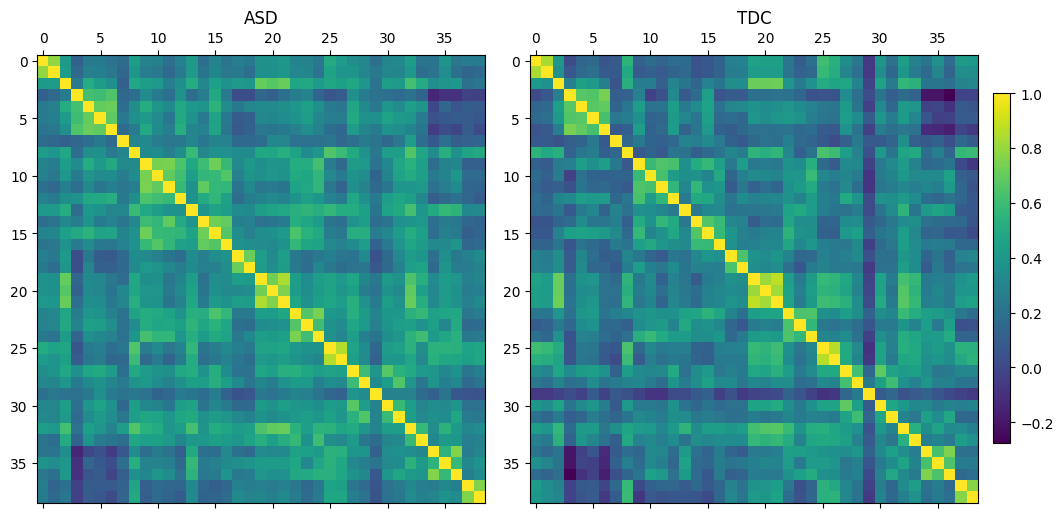

In [39]:
visualize_corr(mean_corr_cort) # visualize cort mean correlation matrices

/var/folders/lg/kgxc1tq55372n0km3vwpwdtm0000gn/T/ipykernel_67158/979966279.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


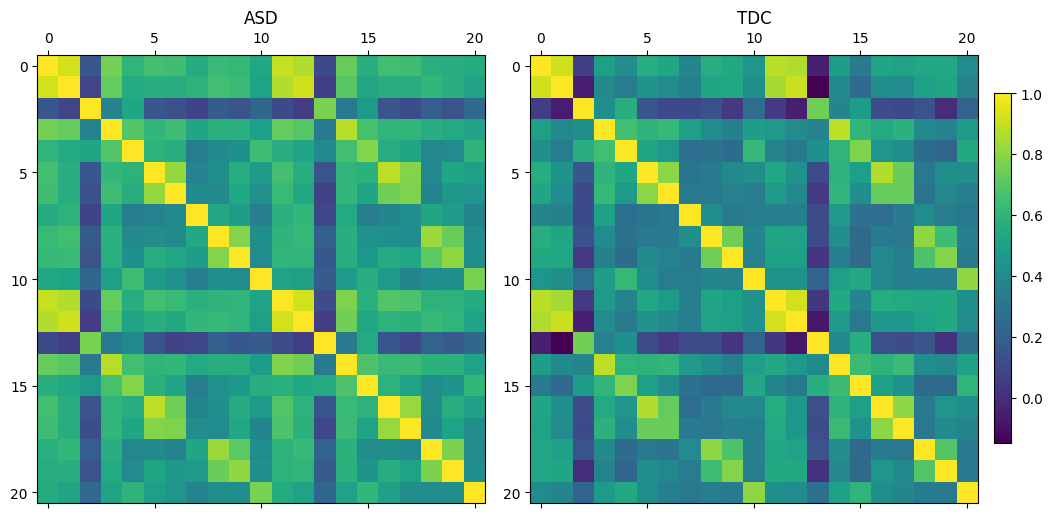

In [40]:
visualize_corr(mean_corr_whole, title='Whole brain') # visualize whole mean correlation matrices

In [43]:
def plot_connectome(mean_correlation_matrix, coords, title='connectome'):
    """
    Plot the connectome using the mean correlation matrix and coordinates.
    """
    # Plotting the connectome
    plotting.plot_connectome(
        mean_correlation_matrix,
        coords,
        title=title,
        edge_threshold="90%",  # Only plot edges above the 90th percentile
        colorbar=True,
        node_size=10,
    )
    plt.show()

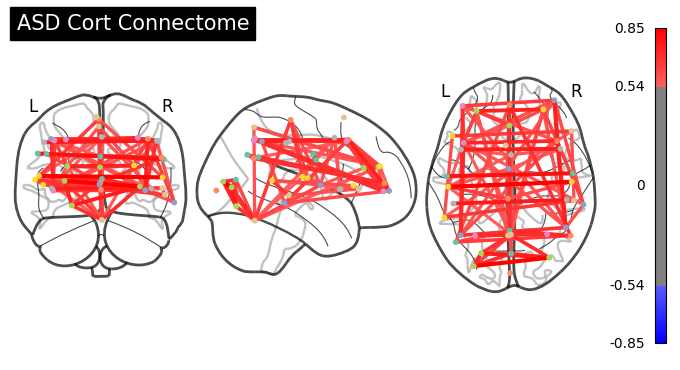

In [44]:
plot_connectome(
    mean_corr_cort['asd'][1],  # Mean correlation matrix for ASD
    msdl_coords,  # Coordinates for MSDL atlas
    title = "ASD Cort Connectome"
)


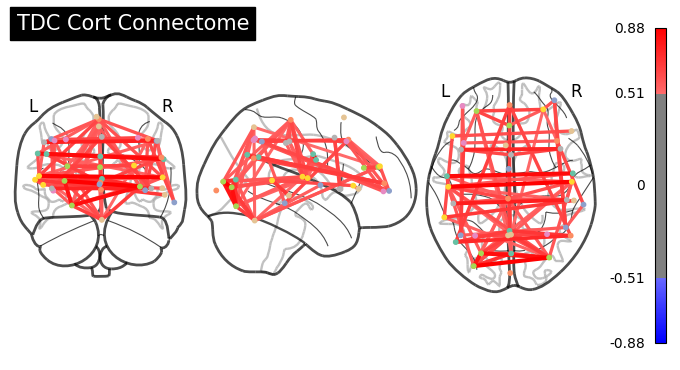

In [45]:
plot_connectome(
    mean_corr_cort['tdc'][1],  # Mean correlation matrix for TDC
    msdl_coords,  # Coordinates for MSDL atlas
    title = "TDC Cort Connectome"
)

In [ ]:
plot_connectome(
    mean_corr_whole['asd'][1],  # Mean correlation matrix for ASD
    whole_coords,  # Coordinates for Harvard-Oxford atlas
    "ASD Whole Connectome"
)

In [ ]:
plot_connectome(
    mean_corr_whole['tdc'][1],  # Mean correlation matrix for TDC
    whole_coords,  # Coordinates for Harvard-Oxford atlas
    "TDC Whole Connectome"
)

## partial correlation

In [48]:
partial_correlation_measure = ConnectivityMeasure(
    kind="partial correlation",
    standardize="zscore_sample",
)

In [49]:
# get cort corr matrices
mean_partial_cort = get_mean_corr(cort_groups, correlation_measure=partial_correlation_measure)

# get cereb corr matrices
# mean_corr_cereb = get_mean_corr(cereb_groups)  

# get whole corr matrices
mean_partial_whole = get_mean_corr(whole_groups, correlation_measure=partial_correlation_measure)

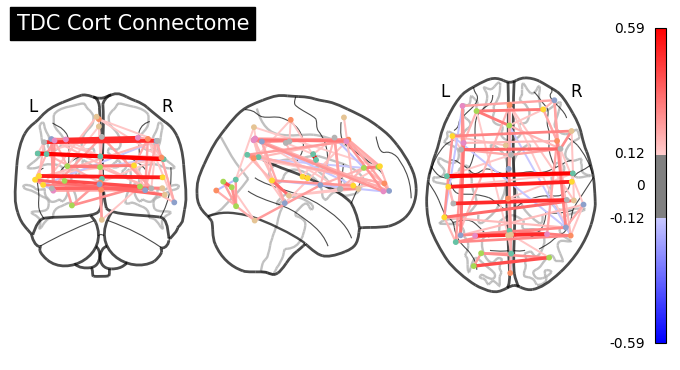

In [52]:
plot_connectome(
    mean_partial_cort['tdc'][1],  # Mean correlation matrix for TDC
    msdl_coords,  # Coordinates for MSDL atlas
    title = "TDC Cort Connectome"
)

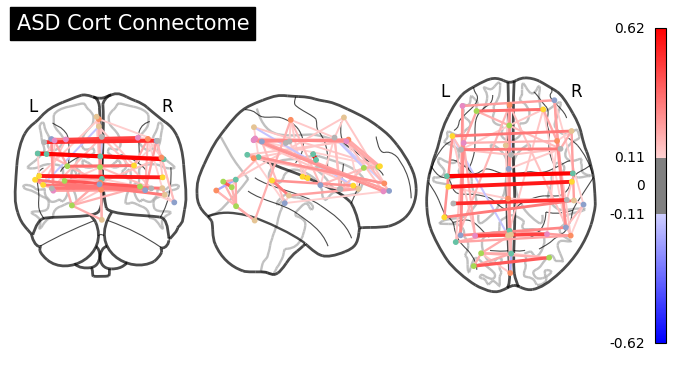

In [53]:
plot_connectome(
    mean_partial_cort['asd'][1],  # Mean correlation matrix for TDC
    msdl_coords,  # Coordinates for MSDL atlas
    title = "ASD Cort Connectome"
)

## tangent measure

In [54]:
tangent_measure = ConnectivityMeasure(
    kind="tangent",
    standardize="zscore_sample",
)

In [55]:
# get cort corr matrices
mean_tangent_cort = get_mean_corr(cort_groups, correlation_measure=partial_correlation_measure)

# get cereb corr matrices
# mean_corr_cereb = get_mean_corr(cereb_groups)  

# get whole corr matrices
mean_tangent_whole = get_mean_corr(whole_groups, correlation_measure=partial_correlation_measure)

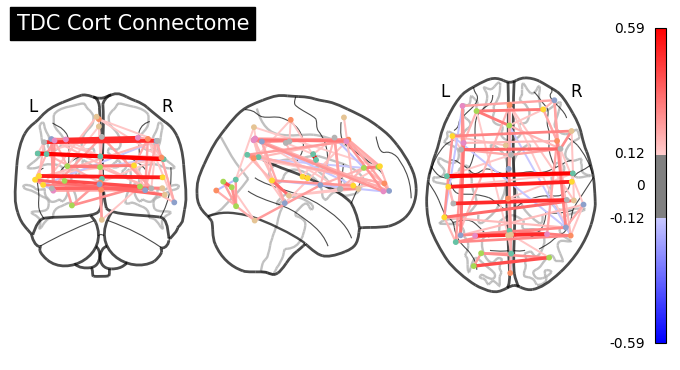

In [56]:
plot_connectome(
    mean_tangent_cort['tdc'][1],  # Mean correlation matrix for TDC
    msdl_coords,  # Coordinates for MSDL atlas
    title = "TDC Cort Connectome"
)

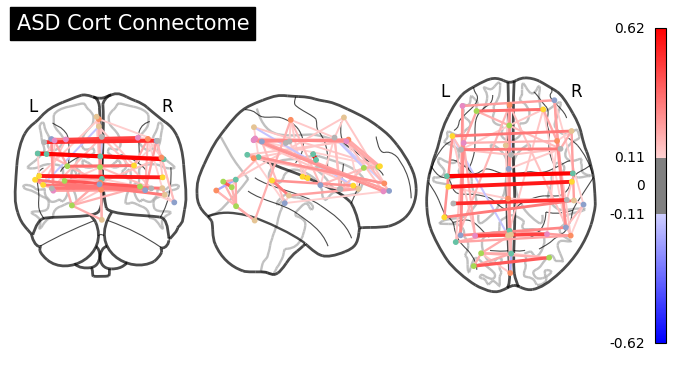

In [58]:
plot_connectome(
    mean_tangent_cort['asd'][1],  # Mean correlation matrix for TDC
    msdl_coords,  # Coordinates for MSDL atlas
    title = "ASD Cort Connectome"
)